### 分析PTT電影版周處除三害相關文章之詞彙關係

目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯

### 大綱

1. 載入套件
2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
3. 找出重要詞彙 - 以TFIDF為例
    - 3.1 計算TF-IDF示範（公式）
    - 3.2 應用於資料集（套件）
    - 3.3 檢視結果
4. 透過結巴斷詞與N-gram幫助建立斷詞字典
    - 4.1 Bigram
    - 4.2 Trigram
    - 4.3 更新斷詞字典
    - 4.4 Bigram視覺化
5. Pairwise correlation
    - 5.1 找出相關性高的詞彙
    - 5.2 畫出關係圖
6. 計算文章相似度

### 1. 載入套件

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
import nltk
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# 使圖中中文能正常顯示
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
# 使負號能夠顯示
plt.rcParams['axes.unicode_minus'] = False 

### 2. 資料前處理

2.1 基本資料介紹

資料來源：

- 工作流程平台蒐集PTT 電影版、八卦版文章
- 關鍵字:「周處除三害」
- 時間: 2023-10-01 ~ 2024-04-04
- 資料筆數：共 599 篇文章

In [5]:
#匯入資料
df = pd.read_csv('./raw_data/movie_1.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,kevin19528,Gossiping,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""mscmobitai"",...",27.53.121.199,2023-10-03 01:31:03,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1696334149....,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,2023-10-03 19:55:47,takuminauki,Gossiping,今年金馬獎最佳男主角競爭激烈\n\n台北電影節最佳男主角\n疫起 王柏傑\n\n金馬獎影帝\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""PanaS0Nic"", ...",114.46.58.46,2023-10-04 01:36:57,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1696506178....,[問卦]租房子有什麼要注意的嗎？,2023-10-05 19:42:56,Hsins,Gossiping,如題啦\n最近聽朋友在那邊聊金馬入圍名單\n聊一聊就聽到他們在說租屋的事\n什麼租房子要除三...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""tearness"", ""...",61.223.222.252,2023-10-06 01:37:57,ptt


### 2.2 資料清理
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [7]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', str(x)) if isinstance(x, str) else '')

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1696334149....,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,2023-10-03 19:55:47,今年金馬獎最佳男主角競爭激烈\n\n台北電影節最佳男主角\n疫起 王柏傑\n\n金馬獎影帝\...,今年金馬獎最佳男主角競爭激烈台北電影節最佳男主角疫起王柏傑金馬獎影帝周處除三害阮經天新生代男...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1696506178....,[問卦]租房子有什麼要注意的嗎？,2023-10-05 19:42:56,如題啦\n最近聽朋友在那邊聊金馬入圍名單\n聊一聊就聽到他們在說租屋的事\n什麼租房子要除三...,如題啦最近聽朋友在那邊聊金馬入圍名單聊一聊就聽到他們在說租屋的事什麼租房子要除三害之類的到底...


### 2.3 文章斷詞與整理

In [20]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')
#新增自定義字典
jieba.load_userdict("dict/user_dict.txt")

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /Users/wuanjie/Desktop/NLP/SocialAnalysis_2nd/dict/dict.txt ...
Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u838ae815cfd34ee3f709b81df81421fa.cache
Loading model cost 1.192 seconds.
Prefix dict has been built successfully.


In [21]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [22]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天
1,2,https://www.ptt.cc/bbs/Gossiping/M.1696334149....,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,2023-10-03 19:55:47,今年金馬獎最佳男主角競爭激烈\n\n台北電影節最佳男主角\n疫起 王柏傑\n\n金馬獎影帝\...,今年金馬獎最佳男主角競爭激烈台北電影節最佳男主角疫起王柏傑金馬獎影帝周處除三害阮經天新生代男...,金馬
2,3,https://www.ptt.cc/bbs/Gossiping/M.1696506178....,[問卦]租房子有什麼要注意的嗎？,2023-10-05 19:42:56,如題啦\n最近聽朋友在那邊聊金馬入圍名單\n聊一聊就聽到他們在說租屋的事\n什麼租房子要除三...,如題啦最近聽朋友在那邊聊金馬入圍名單聊一聊就聽到他們在說租屋的事什麼租房子要除三害之類的到底...,男神


### 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度

- TF (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數
- IDF (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 )

### 3.1 計算TF-IDF

In [23]:
movie_df = MetaData.copy()
movie_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1696334149....,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,2023-10-03 19:55:47,今年金馬獎最佳男主角競爭激烈\n\n台北電影節最佳男主角\n疫起 王柏傑\n\n金馬獎影帝\...,今年金馬獎最佳男主角競爭激烈台北電影節最佳男主角疫起王柏傑金馬獎影帝周處除三害阮經天新生代男...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1696506178....,[問卦]租房子有什麼要注意的嗎？,2023-10-05 19:42:56,如題啦\n最近聽朋友在那邊聊金馬入圍名單\n聊一聊就聽到他們在說租屋的事\n什麼租房子要除三...,如題啦最近聽朋友在那邊聊金馬入圍名單聊一聊就聽到他們在說租屋的事什麼租房子要除三害之類的到底...


In [25]:
# 保留需要的欄位
movie_df = movie_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
movie_df['word'] = movie_df.sentence.apply(getToken).map(' '.join)

movie_df.head()

,system_id,sentence,word
0,1,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天 金馬 男神 阮經天 電影 開播 前照 慣例 放過 幾天要 上映 預告片 加減 放些 國...
1,2,今年金馬獎最佳男主角競爭激烈台北電影節最佳男主角疫起王柏傑金馬獎影帝周處除三害阮經天新生代男...,今年 金馬獎 最佳 主角 競爭 激烈 台北 電影節 最佳 主角 疫起 王柏傑 金馬獎 影帝 ...
2,3,如題啦最近聽朋友在那邊聊金馬入圍名單聊一聊就聽到他們在說租屋的事什麼租房子要除三害之類的到底...,如題 最近 朋友 金馬 入圍 名單 聊一聊 聽到 租屋 事什麼 房子 三害 三害 有沒有 周...
3,4,是這樣的啦軟今天演出周處除三害三害是大白虎大蛟龍還有一害是什麼不是都說周處除三害嗎,今天 演出 周處除三害 三害 白虎 蛟龍 一害 周處除三害
4,5,今天周處除三害上映最近也一堆金馬入圍新聞但有人知道阮經天之前是如何嗎用台灣健保在台灣長大演艋...,今天 周處除三害 上映 最近 一堆 金馬 入圍 新聞 知道 阮經天 台灣 健保 台灣 長大 ...


In [26]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(movie_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一下,一九九五閏,一事,一二,一二名,一仗,一付,一代,一代梗圖,...,龍族,龍會,龍治,龍潭,龍當,龍穴裡,龍門,龐大,龜密,龜頭
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一下,一九九五閏,一事,一二,一二名,一仗,一付,一代,一代梗圖,...,龍族,龍會,龍治,龍潭,龍當,龍穴裡,龍門,龐大,龜密,龜頭
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 檢視結果

方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [28]:
movie_tfidf = TFIDF_df.mean().to_frame().reset_index()
movie_tfidf.columns = ["word", "avg"]

movie_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
2672,台灣,0.038917
13366,電影,0.037711
2894,周處除三害,0.033736
595,中國,0.025191
2893,周處,0.022455
9560,票房,0.021674
13074,阮經天,0.019710
13194,陳桂林,0.019576
9429,知道,0.016959
13671,香港,0.016493


方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [29]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一下,一九九五閏,一事,一二,一二名,一仗,一付,一代,...,龍族,龍會,龍治,龍潭,龍當,龍穴裡,龍門,龐大,龜密,龜頭
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595,596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
8383599,595,龜頭,0.0
8383600,596,龜頭,0.0
8383601,597,龜頭,0.0
8383602,598,龜頭,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [31]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
933,台灣,41
205,中國,39
3938,電影,37
3012,票房,32
3899,陳桂林,32
1024,周處,22
1293,大陸,22
4012,香港,20
1025,周處除三害,18
4077,黑道,18


### 4. 透過結巴斷詞與N-gram幫助建立斷詞字典

N-gram 指文本中連續出現的n個語詞。

透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。

### 4.1 Bigram

In [32]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [33]:
movie_bigram = MetaData.copy()

movie_bigram["word"] = movie_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
movie_bigram = movie_bigram.explode('word')

movie_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天 金馬
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,金馬 男神
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,男神 阮經天


統計最常出現的bigram組合

In [34]:
# 計算每個組合出現的次數
movie_bigram_count = movie_bigram['word'].value_counts().reset_index()

movie_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,台灣 電影,81
1,電影 周處除三害,69
2,這部 電影,60
3,完整 新聞,55
4,最佳 主角,46
5,入圍 最佳,41
6,變成 家人,37
7,家人 那件,37
8,年少 日記,37
9,周處除三害 中國,37


### 4.2 Trigram

In [35]:
movie_trigram = MetaData.copy()

movie_trigram["word"] = movie_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
movie_trigram = movie_trigram.explode('word')

movie_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天 金馬 男神
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,金馬 男神 阮經天
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,男神 阮經天 電影


統計最常出現的trigram組合

In [36]:
# 計算每個組合出現的次數
movie_trigram_count = movie_trigram['word'].value_counts().reset_index()

movie_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,變成 家人 那件,36
2,最佳 原創 電影,23
1,雷文 主文 分隔線,23
3,雷文 防雷 資訊,21
4,新聞 連結 網址,19
5,完整 新聞 連結,19
6,連結 網址 不可,19
7,網址 不可 轉載,19
8,不可 轉載 媒體,19
11,完整 新聞 內文,18


從上面的 bigram 和 trigram 的結果中，我們發現"原創 電影"、"新聞 連結" 、"完整 新聞"、"不可 轉載"等詞可以組合在一起，

所以我們增加自定義字典來幫助斷詞能更準確。
我們將詞彙整理好存在 dict 文件夾中的 movie.txt 中。

4.3 使用自建字典

In [37]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/movie.txt')

使用自建辭典進行斷詞與計算

In [38]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,金馬
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,男神


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [39]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天 金馬
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,金馬 男神
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,男神 阮經天


In [40]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('台灣', '電影'), 81),
 (('電影', '周處除三害'), 69),
 (('這部', '電影'), 60),
 (('最佳', '主角'), 46),
 (('入圍', '最佳'), 41)]

In [41]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [42]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

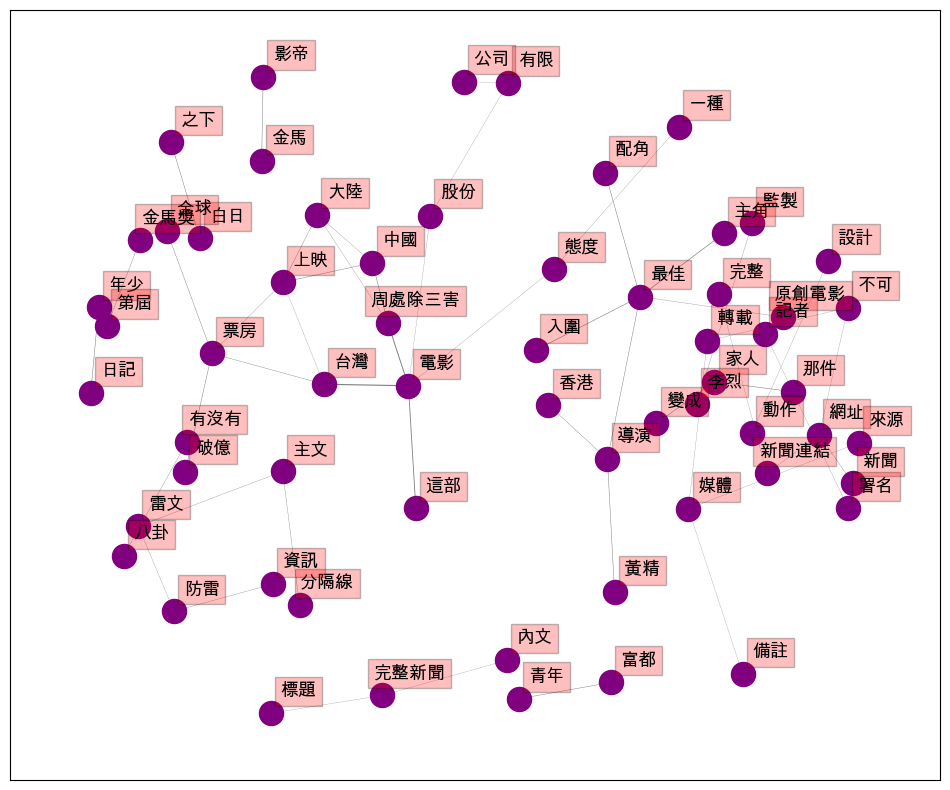

In [43]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 5. Pairwise correlation

計算兩個詞彙間的相關性 Pearson correlation

In [44]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天 金馬 男神 阮經天 電影 開播 前照 慣例 放過 幾天要 上映 預告片 加減 放些 國...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1696334149....,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,2023-10-03 19:55:47,今年金馬獎最佳男主角競爭激烈\n\n台北電影節最佳男主角\n疫起 王柏傑\n\n金馬獎影帝\...,今年金馬獎最佳男主角競爭激烈台北電影節最佳男主角疫起王柏傑金馬獎影帝周處除三害阮經天新生代男...,今年 金馬獎 最佳 主角 競爭 激烈 台北 電影節 最佳 主角 疫起 王柏傑 金馬獎 影帝 ...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1696506178....,[問卦]租房子有什麼要注意的嗎？,2023-10-05 19:42:56,如題啦\n最近聽朋友在那邊聊金馬入圍名單\n聊一聊就聽到他們在說租屋的事\n什麼租房子要除三...,如題啦最近聽朋友在那邊聊金馬入圍名單聊一聊就聽到他們在說租屋的事什麼租房子要除三害之類的到底...,如題 最近 朋友 金馬 入圍 名單 聊一聊 聽到 租屋 事什麼 房子 三害 三害 有沒有 周...


In [45]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一下,一堆,一次,一直,一種,一部,一點,三害,上映,不用,...,預告,題材,類似,類型,風格,飾演,香港,黃精,黑幫,黑道
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
595,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
597,0,0,0,1,0,0,2,0,1,1,...,0,0,0,0,0,1,6,0,0,0


In [46]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一下,一堆,一次,一直,一種,一部,一點,三害,上映,...,預告,題材,類似,類型,風格,飾演,香港,黃精,黑幫,黑道
0,一下,1.000000,0.019585,0.187916,0.076270,0.057436,0.097833,0.093220,-0.030310,0.048907,...,-0.051567,0.080463,0.153021,-0.023516,0.040228,-0.007568,0.077884,0.161911,-0.038840,-0.025091
1,一堆,0.019585,1.000000,0.016626,-0.033505,-0.025195,-0.044915,-0.004399,-0.054957,-0.039345,...,-0.010262,-0.011749,0.012581,-0.023978,-0.035602,0.034544,0.030857,-0.040843,-0.000601,0.129346
2,一次,0.187916,0.016626,1.000000,0.089360,0.210776,0.181911,0.067665,-0.033222,0.106701,...,-0.013235,0.079621,0.221157,0.067900,0.043495,0.153183,0.241359,0.293177,0.061503,0.119933
3,一直,0.076270,-0.033505,0.089360,1.000000,0.123321,0.148978,0.170009,-0.026208,0.053512,...,0.025949,0.210395,0.030141,0.232886,0.088866,0.064997,0.295976,0.184029,0.220485,-0.024952
4,一種,0.057436,-0.025195,0.210776,0.123321,1.000000,0.178571,0.042271,-0.031135,0.197726,...,-0.018221,0.168205,0.179230,0.364206,0.213792,0.219162,0.232941,0.289857,0.100280,-0.037753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,飾演,-0.007568,0.034544,0.153183,0.064997,0.219162,0.169058,0.081261,0.108675,0.175792,...,-0.003533,0.130572,0.038638,0.392077,0.274514,1.000000,0.492102,0.173031,0.183467,0.091642
296,香港,0.077884,0.030857,0.241359,0.295976,0.232941,0.290579,0.242651,0.146766,0.152482,...,0.009797,0.263562,0.028811,0.652779,0.460999,0.492102,1.000000,0.430340,0.479656,0.184004
297,黃精,0.161911,-0.040843,0.293177,0.184029,0.289857,0.373514,0.062300,0.068960,0.159720,...,0.167062,0.098417,0.232518,0.313348,0.234314,0.173031,0.430340,1.000000,0.225753,0.057597
298,黑幫,-0.038840,-0.000601,0.061503,0.220485,0.100280,0.320050,0.390563,-0.008386,0.101053,...,0.029810,0.282439,-0.017249,0.472462,0.157225,0.183467,0.479656,0.225753,1.000000,0.079794


In [47]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
59117,之下,白日,0.986064
5297,白日,之下,0.986064
43610,年少,日記,0.983522
33145,日記,年少,0.983522
14114,主文,分隔線,0.979726
4247,分隔線,主文,0.979726
11618,累積,全球,0.979191
65438,全球,累積,0.979191
18638,全球,台幣,0.972694
11462,台幣,全球,0.972694


可以看到列出的詞彙都有非常高的相關性，意味著這些詞彙在某些文章中往往一起出現。
 
 《年少日記》、《白日之下》等影片，都在 2023 年底中國廈門舉行的電影金雞獎，獲得了展映機會。其中甚至有在 2024 獲得全國公映的機會，包括《白日之下》、《年少日記》、《周處除三害》。而《周處除三害》只是其中比較有市場緣的作品，並因此獲得了極大的市場回報。



### 5.1 和 「阮經天」, 「抄襲」 相關性最高的 10 個詞彙

In [63]:
person_sum = word_cor_df[(word_cor_df["word1"] == "阮經天")].sort_values(by = ['cor'], ascending = False).head(10)
article_sum = word_cor_df[(word_cor_df["word1"] == "抄襲")].sort_values(by = ['cor'], ascending = False).head(10)

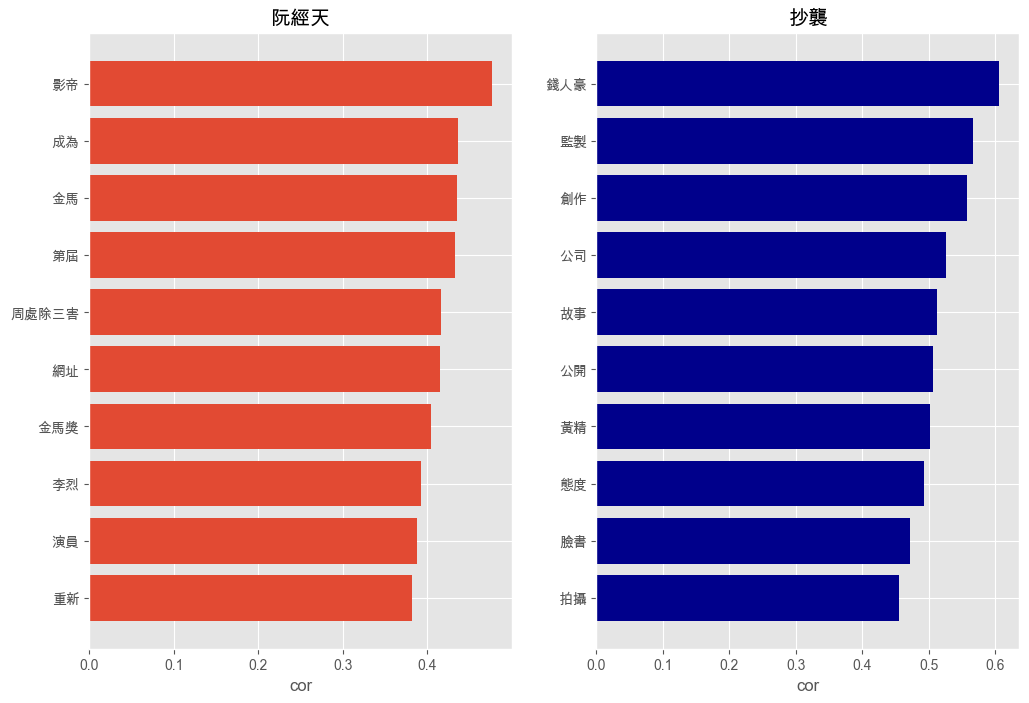

In [65]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('阮經天')
plt.xlabel('cor')
plt.barh(person_sum['word2'],person_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('抄襲')
plt.xlabel('cor')
plt.barh(article_sum['word2'],article_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

可以看到「抄襲」的詞彙出現頻率最高的是導演「錢人豪」，可以從近期新聞中得知，導演錢人豪近日在臉書指控《周處除三害》抄襲他多年前的作品《無法無天》，引起各方熱烈的討論。

而關於「阮經天」有高相關性的詞彙，有「金馬」「影帝」，可以透漏出阮經天的演技被認為是影帝級別的！

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [61]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [62]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,周處,一下,0.304451
1,故事,一下,0.313276
2,作品,一部,0.359258
3,台灣,一部,0.303727
4,故事,一部,0.443647
...,...,...,...
403,導演,黃精,0.624845
404,抄襲,黃精,0.502448
405,故事,黃精,0.602024
406,電影,黃精,0.457316


In [66]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

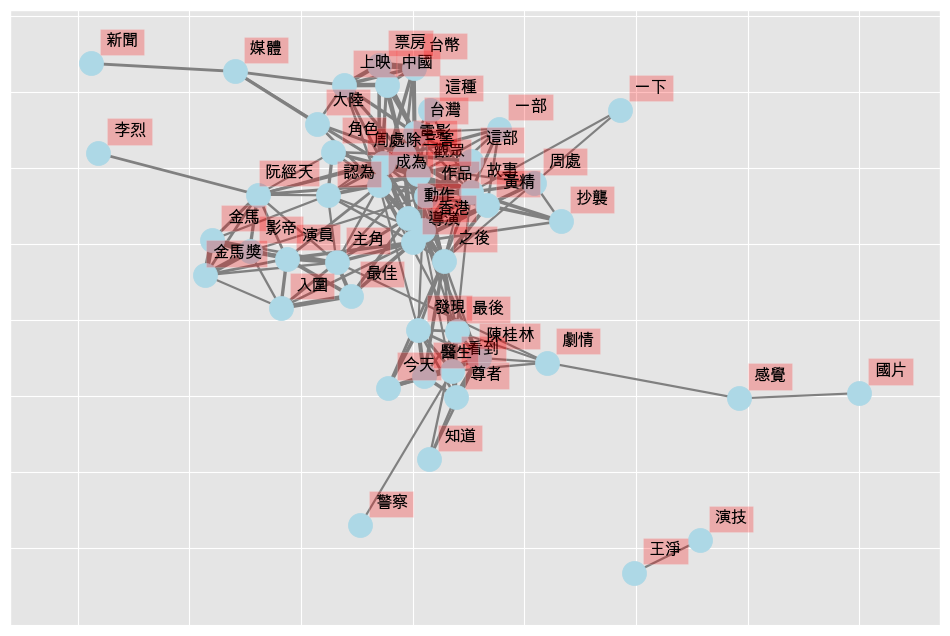

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    

### 6. 計算文章相似度

以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章

In [68]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...,昨天 金馬 男神 阮經天 電影 開播 前照 慣例 放過 幾天要 上映 預告片 加減 放些 國...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1696334149....,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,2023-10-03 19:55:47,今年金馬獎最佳男主角競爭激烈\n\n台北電影節最佳男主角\n疫起 王柏傑\n\n金馬獎影帝\...,今年金馬獎最佳男主角競爭激烈台北電影節最佳男主角疫起王柏傑金馬獎影帝周處除三害阮經天新生代男...,今年 金馬獎 最佳 主角 競爭 激烈 台北 電影節 最佳 主角 疫起 王柏傑 金馬獎 影帝 ...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1696506178....,[問卦]租房子有什麼要注意的嗎？,2023-10-05 19:42:56,如題啦\n最近聽朋友在那邊聊金馬入圍名單\n聊一聊就聽到他們在說租屋的事\n什麼租房子要除三...,如題啦最近聽朋友在那邊聊金馬入圍名單聊一聊就聽到他們在說租屋的事什麼租房子要除三害之類的到底...,如題 最近 朋友 金馬 入圍 名單 聊一聊 聽到 租屋 事什麼 房子 三害 三害 有沒有 周...


In [69]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一下,一堆,一次,一直,一種,一部,一點,三害,上映,不用,...,預告,題材,類似,類型,風格,飾演,香港,黃精,黑幫,黑道
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.193505,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.556143,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.490166,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.147614,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.117510,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
595,0.0,0.580352,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
596,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.055809,0.0,0.0,0.0
597,0.0,0.000000,0.0,0.072514,0.000000,0.0,0.160786,0.000000,0.057402,0.09011,...,0.0,0.0,0.000000,0.0,0.0,0.085824,0.345615,0.0,0.0,0.0


計算文章間的cosine similarity

In [70]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [71]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.099542
2,0.135178
3,0.052937
4,0.210115
...,...
594,0.000000
595,0.113220
596,0.166815
597,0.108606


In [72]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[問卦]今年是國片元年嗎？,https://www.ptt.cc/bbs/Gossiping/M.1696222497....
210,0.444624,[問卦]看到林祿和的裸體奮發減肥的人多嗎==,https://www.ptt.cc/bbs/Gossiping/M.1710172455....
39,0.420543,[問卦]為什周處除三害在對岸票房可以破億？,https://www.ptt.cc/bbs/Gossiping/M.1709393646....
589,0.399060,Re:[普負雷]要cult不cult的周處除三害,https://www.ptt.cc/bbs/movie/M.1711196011.A.73...
37,0.386967,[問卦]豆瓣8.4的周處除三害好看嗎?,https://www.ptt.cc/bbs/Gossiping/M.1709350735....
137,0.365463,Re:[問卦]周處除三害台灣票房怎麼這麼淒慘？,https://www.ptt.cc/bbs/Gossiping/M.1709821021....
38,0.331257,[問卦]要吃到什麼東西才會吐黑水啊？！,https://www.ptt.cc/bbs/Gossiping/M.1709352535....
6,0.321336,[問卦]大膽預測周處除三害會破億,https://www.ptt.cc/bbs/Gossiping/M.1696821659....
446,0.319529,[討論]周處除三害得到上海票房日冠軍,https://www.ptt.cc/bbs/movie/M.1709229163.A.1B...
69,0.289457,[問卦]周處的槍也太會卡彈了吧?,https://www.ptt.cc/bbs/Gossiping/M.1709515205....


檢視與第10篇文章相似的文章

In [74]:
cos_df_14 = pd.DataFrame(cosine_matrix[10], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
10,1.000000,Re:[新聞]錢人豪正式提告了！公開《周處除三害》,https://www.ptt.cc/bbs/Gossiping/M.1697610016....
503,0.498764,Re:[討論]所以為啥周處在台灣沒紅？,https://www.ptt.cc/bbs/movie/M.1709795482.A.B7...
578,0.417251,Re:[雷]周處除三害對於信徒的疑問,https://www.ptt.cc/bbs/movie/M.1710830155.A.19...
413,0.377504,[討論]周處除三害小分享（有雷慎入）,https://www.ptt.cc/bbs/movie/M.1698587205.A.40...
151,0.347448,Re:[問卦]陳桂林不可教化嗎？,https://www.ptt.cc/bbs/Gossiping/M.1710044610....
320,0.331271,Re:[問卦]2岸開戰媽祖會幫哪一邊啊?,https://www.ptt.cc/bbs/Gossiping/M.1710903396....
16,0.317645,Re:[新聞]評柯文哲7大當選承諾 前大法官示警：內閣制可能更不受,https://www.ptt.cc/bbs/Gossiping/M.1698395071....
479,0.312160,Re:[討論]周處除三害在台灣不火在中國超火,https://www.ptt.cc/bbs/movie/M.1709690399.A.83...
583,0.301114,[雷]周處除三害心得,https://www.ptt.cc/bbs/movie/M.1710945417.A.7A...
156,0.295844,[問卦]會覺得中國無神論其實還蠻先進的嗎,https://www.ptt.cc/bbs/Gossiping/M.1710067234....
